## Préparation des données

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from keras import layers, applications, utils, models, optimizers, Input, callbacks
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
# Importer les données avec les 14 colonnes sélectionnées via différentes méthodes de feature selection
# Colonnes supprimées pour le test : "distRealSR2", "senderPseudo", "sender", "sendTime", "scenario", "rcvTime"

data = pd.read_csv(
    "./data/DoS_0709_new_columns.csv",
    usecols=[
        "distance",
        "distRealSR1",
        "receiver",
        "pos_y_rec_f",
        "pos_x_rec_f",
        "pos_x_rec",
        "nb_packets_sent",
        "messageID",
        "label",
    ],
    index_col=False,
)

In [4]:
# On prend seulement une partie des données choisies aléatoirement pour avoir un nombre aléatoire d'attaques et de comportement normal
sample_data = data.sample(2000)

print("Nombre de lignes avant nettoyage : ", sample_data.shape[0])

# On remplace les données infinies par nan si elles existent
sample_data.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop les lignes avec nan
sample_data.dropna(inplace=True)

print("Nombre de lignes après nettoyage : ", sample_data.shape[0])

Nombre de lignes avant nettoyage :  2000
Nombre de lignes après nettoyage :  1974


In [5]:
# Transformation en array numpy
X = np.array(sample_data.drop(["label"], axis=1))
y = np.array(sample_data["label"])

In [6]:
# On remplace les valeurs "13" correspondant à une attaque DoS par "1" pour utiliser la fonction to_categorical
# Dans ce cas, 1 correspond à une attaque et 0 correspond à un message normal
for i in range(len(y)):
    if y[i]==13:
        y[i]=1

In [7]:
# Verification
y[:10]

array([1, 0, 0, 1, 0, 0, 1, 0, 1, 1], dtype=int64)

In [8]:
y = keras.utils.to_categorical(y, num_classes=2)

In [9]:
# Verification
y[:10]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [10]:
# Séparation en données d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [11]:
print("X_train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X_train :  (1776, 8)
y_train :  (1776, 2)
X_test :  (198, 8)
y_test :  (198, 2)


## Réseau simple

In [250]:
simple_model = keras.Sequential([
    layers.Dense(32,input_shape=(X_train.shape[1],), activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [251]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [252]:
opt = keras.optimizers.SGD(learning_rate=0.1)
simple_model.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')

In [253]:
history = simple_model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2, validation_split=0.3)

Epoch 1/20
10/10 - 5s - loss: 0.3067 - accuracy: 0.5193 - val_loss: 0.2916 - val_accuracy: 0.5412 - 5s/epoch - 458ms/step
Epoch 2/20
10/10 - 0s - loss: 0.2867 - accuracy: 0.5322 - val_loss: 0.2846 - val_accuracy: 0.4569 - 391ms/epoch - 39ms/step
Epoch 3/20
10/10 - 0s - loss: 0.2707 - accuracy: 0.5498 - val_loss: 0.2906 - val_accuracy: 0.4494 - 293ms/epoch - 29ms/step
Epoch 4/20
10/10 - 0s - loss: 0.2758 - accuracy: 0.5297 - val_loss: 0.2822 - val_accuracy: 0.4682 - 281ms/epoch - 28ms/step
Epoch 5/20
10/10 - 0s - loss: 0.2660 - accuracy: 0.5338 - val_loss: 0.2722 - val_accuracy: 0.4719 - 391ms/epoch - 39ms/step
Epoch 6/20
10/10 - 0s - loss: 0.2552 - accuracy: 0.5305 - val_loss: 0.2674 - val_accuracy: 0.4775 - 376ms/epoch - 38ms/step


7/7 [==============================] - 0s 15ms/step - loss: 0.2873 - accuracy: 0.5606
Evaluation du modèle : [0.2872598171234131, 0.560606062412262]
7/7 [==============================] - 0s 16ms/step


Text(33.0, 0.5, 'True Labels')

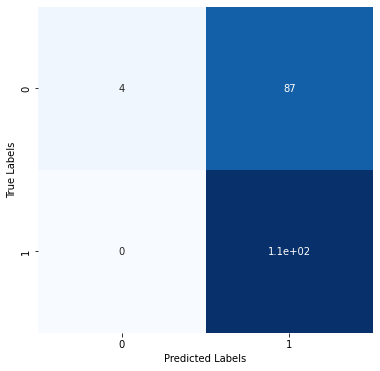

In [257]:
print(f"Evaluation du modèle : {simple_model.evaluate(X_test, y_test)}")
y_pred = simple_model.predict(X_test)
preds = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

## Test simple avec la bibliothèque Keras
https://machinelearningmastery.com/understanding-simple-recurrent-neural-networks-in-keras/

In [264]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    '''
    hidden_units : nombre de neurones dans la couche SimpleRNN
    dense_units : nombre de neurones dans la couche Dense
    activation : liste des deux fonctions d'activation
    '''
    opt = keras.optimizers.SGD(learning_rate=0.1)
    model = Sequential()
    model.add(SimpleRNN(hidden_units, input_shape=input_shape, return_sequences=True,
                        activation=activation[0]))
    model.add(SimpleRNN(32, activation=activation[0]))
    model.add(keras.layers.BatchNormalization())
    model.add(Dense(64, activation=activation[1]))
    model.add(Dense(units=dense_units, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer=opt, metrics='accuracy')
    return model

#demo_model = create_RNN(2, 1, (3,1), activation=['linear', 'linear'])

demo_model = create_RNN(32, 1, (X_train.shape[1],1), activation=['tanh', 'tanh'])

In [213]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [265]:
history = demo_model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=2, validation_split=0.3)

Epoch 1/20
10/10 - 8s - loss: 0.2622 - accuracy: 0.4952 - val_loss: 0.2533 - val_accuracy: 0.5225 - 8s/epoch - 761ms/step
Epoch 2/20
10/10 - 0s - loss: 0.2521 - accuracy: 0.5080 - val_loss: 0.2532 - val_accuracy: 0.5206 - 367ms/epoch - 37ms/step
Epoch 3/20
10/10 - 0s - loss: 0.2489 - accuracy: 0.5466 - val_loss: 0.2527 - val_accuracy: 0.5206 - 301ms/epoch - 30ms/step
Epoch 4/20
10/10 - 0s - loss: 0.2491 - accuracy: 0.5450 - val_loss: 0.2517 - val_accuracy: 0.5112 - 344ms/epoch - 34ms/step
Epoch 5/20
10/10 - 0s - loss: 0.2480 - accuracy: 0.5539 - val_loss: 0.2515 - val_accuracy: 0.5243 - 292ms/epoch - 29ms/step
Epoch 6/20
10/10 - 0s - loss: 0.2467 - accuracy: 0.5603 - val_loss: 0.2510 - val_accuracy: 0.5169 - 300ms/epoch - 30ms/step
Epoch 7/20
10/10 - 0s - loss: 0.2468 - accuracy: 0.5531 - val_loss: 0.2506 - val_accuracy: 0.5075 - 275ms/epoch - 28ms/step
Epoch 8/20
10/10 - 0s - loss: 0.2472 - accuracy: 0.5450 - val_loss: 0.2501 - val_accuracy: 0.5075 - 286ms/epoch - 29ms/step
Epoch 9/20

Courbes d'apprentissage

<AxesSubplot:>

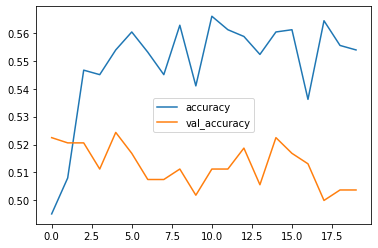

In [266]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

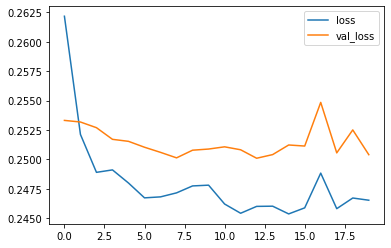

In [267]:
history_df.loc[:, ['loss', 'val_loss']].plot()

7/7 [==============================] - 0s 8ms/step - loss: 0.2446 - accuracy: 0.5960
Evaluation du modèle : [0.24456235766410828, 0.5959596037864685]
7/7 [==============================] - 2s 8ms/step


Text(33.0, 0.5, 'True Labels')

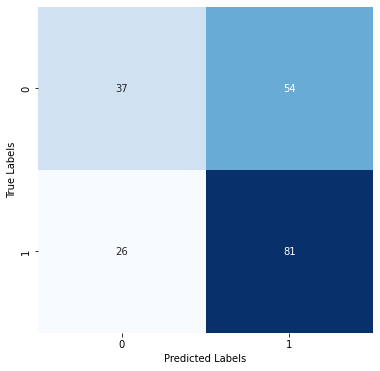

In [268]:
print(f"Evaluation du modèle : {demo_model.evaluate(X_test, y_test)}")
y_pred = demo_model.predict(X_test)
preds = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

## Test avec LSTM de Keras

In [269]:
lstm_model = keras.Sequential([
    layers.Dense(32,input_shape=(X_train.shape[1],1), activation='relu'),
    layers.LSTM(128),
    layers.Dense(1, activation='sigmoid')
])

In [270]:
lstm_model.summary()

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 8, 32)             64        
                                                                 
 lstm_20 (LSTM)              (None, 128)               82432     
                                                                 
 dense_118 (Dense)           (None, 1)                 129       
                                                                 
Total params: 82,625
Trainable params: 82,625
Non-trainable params: 0
_________________________________________________________________


In [271]:
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [273]:
history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=2, validation_split=0.3)

Epoch 1/20
39/39 - 2s - loss: 0.6894 - accuracy: 0.5498 - val_loss: 0.6942 - val_accuracy: 0.5449 - 2s/epoch - 41ms/step
Epoch 2/20
39/39 - 1s - loss: 0.6879 - accuracy: 0.5619 - val_loss: 0.6958 - val_accuracy: 0.5431 - 1s/epoch - 38ms/step
Epoch 3/20
39/39 - 1s - loss: 0.6847 - accuracy: 0.5635 - val_loss: 0.6951 - val_accuracy: 0.5468 - 1s/epoch - 34ms/step
Epoch 4/20
39/39 - 1s - loss: 0.6862 - accuracy: 0.5675 - val_loss: 0.6965 - val_accuracy: 0.5412 - 1s/epoch - 27ms/step
Epoch 5/20
39/39 - 1s - loss: 0.6845 - accuracy: 0.5627 - val_loss: 0.6986 - val_accuracy: 0.5468 - 1s/epoch - 31ms/step
Epoch 6/20
39/39 - 2s - loss: 0.6848 - accuracy: 0.5619 - val_loss: 0.6969 - val_accuracy: 0.5412 - 2s/epoch - 41ms/step
Epoch 7/20
39/39 - 1s - loss: 0.6836 - accuracy: 0.5643 - val_loss: 0.6967 - val_accuracy: 0.5375 - 1s/epoch - 36ms/step
Epoch 8/20
39/39 - 1s - loss: 0.6849 - accuracy: 0.5611 - val_loss: 0.7003 - val_accuracy: 0.4513 - 1s/epoch - 33ms/step
Epoch 9/20
39/39 - 2s - loss: 0.

Courbes d'apprentissage

<AxesSubplot:>

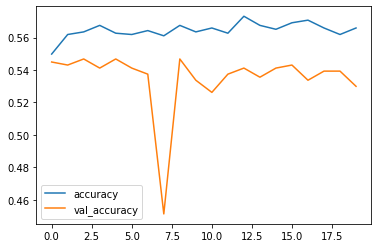

In [274]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

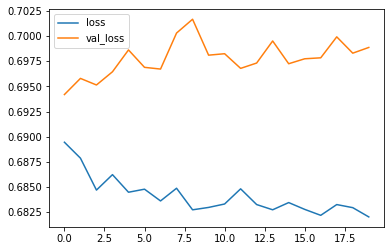

In [275]:
history_df.loc[:, ['loss', 'val_loss']].plot()

7/7 [==============================] - 0s 14ms/step - loss: 0.6898 - accuracy: 0.5505
Evaluation du modèle : [0.6897702217102051, 0.5505050420761108]
7/7 [==============================] - 2s 14ms/step


Text(33.0, 0.5, 'True Labels')

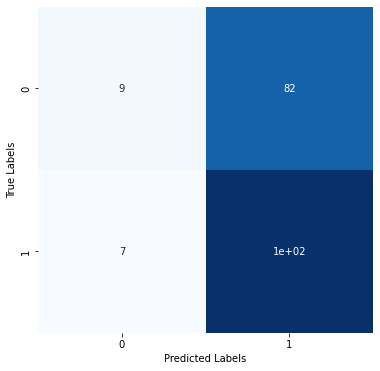

In [276]:
print(f"Evaluation du modèle : {lstm_model.evaluate(X_test, y_test)}")
y_pred = lstm_model.predict(X_test)
preds = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

## Test avec mélanges de SimpleRNN et LSTM

In [287]:
lstm_rnn_model = keras.Sequential([
    layers.Dense(32,input_shape=(X_train.shape[1],1), activation='relu'),
    layers.LSTM(128, return_sequences=True, activation='relu'), # return_sequences à True pour que la sortie soit de dimension 3
    layers.SimpleRNN(64,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

In [288]:
opt = keras.optimizers.SGD(learning_rate=0.1)
lstm_rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

In [289]:
history = lstm_rnn_model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=2, validation_split=0.3)

Epoch 1/15
39/39 - 11s - loss: 240666.9844 - accuracy: 0.4952 - val_loss: 85654.8594 - val_accuracy: 0.4551 - 11s/epoch - 281ms/step
Epoch 2/15
39/39 - 2s - loss: 69316.7656 - accuracy: 0.5161 - val_loss: 18742.1719 - val_accuracy: 0.5449 - 2s/epoch - 43ms/step
Epoch 3/15
39/39 - 2s - loss: 132571.3750 - accuracy: 0.5201 - val_loss: 38687.6758 - val_accuracy: 0.5468 - 2s/epoch - 52ms/step
Epoch 4/15
39/39 - 1s - loss: 95365.6797 - accuracy: 0.5016 - val_loss: 37363.9844 - val_accuracy: 0.5468 - 1s/epoch - 36ms/step
Epoch 5/15
39/39 - 1s - loss: 76652.5000 - accuracy: 0.4783 - val_loss: 14067.2314 - val_accuracy: 0.4532 - 1s/epoch - 36ms/step
Epoch 6/15
39/39 - 2s - loss: 41584.8438 - accuracy: 0.5056 - val_loss: 18024.5117 - val_accuracy: 0.5468 - 2s/epoch - 40ms/step
Epoch 7/15
39/39 - 1s - loss: 62600.5781 - accuracy: 0.5129 - val_loss: 66093.9297 - val_accuracy: 0.5487 - 1s/epoch - 37ms/step
Epoch 8/15
39/39 - 2s - loss: 28114.3691 - accuracy: 0.5024 - val_loss: 17212.2949 - val_acc

Courbes d'apprentissage

<AxesSubplot:>

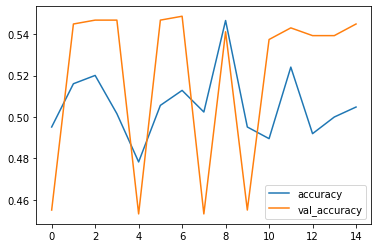

In [290]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

<AxesSubplot:>

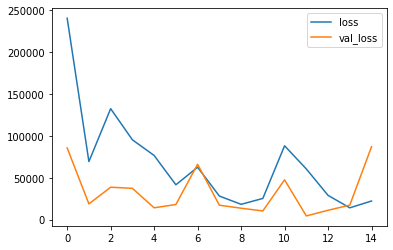

In [291]:
history_df.loc[:, ['loss', 'val_loss']].plot()

7/7 [==============================] - 0s 25ms/step - loss: 81576.7500 - accuracy: 0.5404
Evaluation du modèle : [81576.75, 0.5404040217399597]
7/7 [==============================] - 2s 15ms/step


Text(33.0, 0.5, 'True Labels')

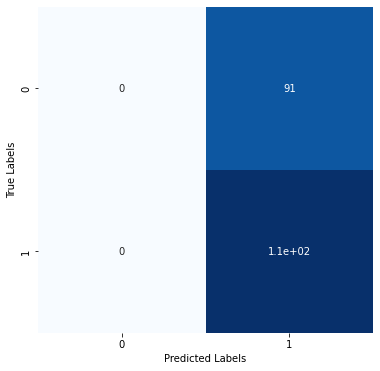

In [292]:
print(f"Evaluation du modèle : {lstm_rnn_model.evaluate(X_test, y_test)}")
y_pred = lstm_rnn_model.predict(X_test)
preds = np.round(y_pred).astype(int)
cm = confusion_matrix(y_test, preds)
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(cm, annot=True, cbar=False, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

## Test avec : https://peterroelants.github.io/posts/rnn-implementation-part01/#Final-model

In [230]:
import rnn

eta_p = 1.2
eta_n = 0.5

# Set initial parameters
W = [-1.5, 2]  # [wx, wRec]
W_delta = [0.001, 0.001]  # Update values (Delta) for W
W_sign = [0, 0]  # Previous sign of W

ls_of_ws = [(W[0], W[1])]  # List of weights to plot
# Iterate over 500 iterations
for i in range(500):
    # Get the update values and sign of the last gradient
    W_delta, W_sign = rnn.update_rprop(
        X_train, y, W, W_sign, W_delta, eta_p, eta_n)
    # Update each weight parameter seperately
    for i, _ in enumerate(W):
        W[i] -= W_sign[i] * W_delta[i]
    ls_of_ws.append((W[0], W[1]))  # Add weights to list to plot

print(f'Final weights are: wx = {W[0]:.4f},  wRec = {W[1]:.4f}')

ValueError: operands could not be broadcast together with shapes (1778,) (1976,2) 

## Test avec : https://github.com/WillKoehrsen/recurrent-neural-networks

In [ ]:
from tensorflow import keras
from keras import layers, applications, utils, models, optimizers, Input

# Modèle déjà existant téléchargé sur le github en titre
imported_rnn = keras.models.load_model('./train-embeddings-rnn.h5')

In [ ]:
imported_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1619200   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 16192)             2088768   
                                                                 
Total params: 3,758,528
Trainable params: 3,758,528
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Ajout de couches d'entrée et de sortie pour que le modèle soit adapté à nos données
model = models.Sequential([
    Input(shape=(14,)),
    layers.Dense(32,activation='relu'),
    imported_rnn,
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                480       
                                                                 
 sequential_2 (Sequential)   (None, 16192)             3758528   
                                                                 
 dense_1 (Dense)             (None, 1)                 16193     
                                                                 
Total params: 3,775,201
Trainable params: 3,775,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [ ]:
training_history = model.fit(x=X_train, y=y_train, epochs=10, validation_split=0.3, shuffle=True, batch_size=64)

# Problème au niveau de la couche embeddings